### Accessing data

In [1]:
import subprocess
import numpy as np

# List of recids for which you want to obtain file locations
recids = ["67993", "69747", "67841", "67801"]

all_filenames = []
for recid in recids:
    command = ["cernopendata-client", "get-file-locations", "--recid", recid, "--protocol", "xrootd"]
    result = subprocess.run(command, capture_output=True, text=True)
    filenames = result.stdout.splitlines()
    all_filenames.extend(filenames)

filenames_bkg = np.array(all_filenames)

command = ["cernopendata-client", "get-file-locations", "--recid", "75156", "--protocol", "xrootd"]
result = subprocess.run(command, capture_output=True, text=True)
filenames = result.stdout.splitlines()
filenames_sig = np.array(filenames)

print(filenames_bkg)
print(filenames_sig)

['root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/08FCB2ED-176B-064B-85AB-37B898773B98.root'
 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/0BD60695-8388-5141-B157-32AE1A3B4885.root'
 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/0F91D1FB-8209-154F-BBD4-DD8A3BF8E20B.root'
 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/18C263F0-0CA5-EF45-A6D4-E4FE3578ADE4.root'
 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptot

The recids are as follows:
- **signal_M2000**: `"75156"`
- **ttsemilep**: `"67993"`
- **tthadronic**: `"67841"`
- **ttleptonic**: `"67801"`
- **Wjets**: `"69747"`

In [2]:
import uproot
import matplotlib.pylab as plt
import awkward as ak
import numpy as np
from glob import glob

treename = "Events"
# Dictionary defining the objects and their respective variables to extract
branch_dict = {
                "Muon": ["pt", "eta", "phi"],
                "Electron": ["pt", "eta", "phi"],
                "FatJet": ["pt", "eta", "phi"]
            }

# make list of branches to read from the dictionary above
branch_names = []
for obj, var in branch_dict.items(): 
    branch_names += [obj + "_" + v for v in var]

infiles_sig = filenames_sig[:] 

data_sig = uproot.concatenate({fname:"Events" for fname in infiles_sig}, 
                              branch_names, 
                              how = "zip",
                              library = "ak")

infiles_bkg = filenames_bkg[6:12] 
data_bkg = uproot.concatenate({fname:"Events" for fname in infiles_bkg}, 
                              branch_names, 
                              how = "zip",
                              library = "ak")

Now, each object is grouped in its respective field, and the variables are accessible at the next level (result of using `how="zip"` when loading).

In [3]:
data_sig.fields

['Muon', 'Electron', 'FatJet']

In [4]:
data_sig.FatJet.fields

['pt', 'eta', 'phi']

In [5]:
print(f"Training on N signal samples: {len(data_sig)}")
print(f"Training on N backgr samples: {len(data_bkg)}")

Training on N signal samples: 527279
Training on N backgr samples: 6565000


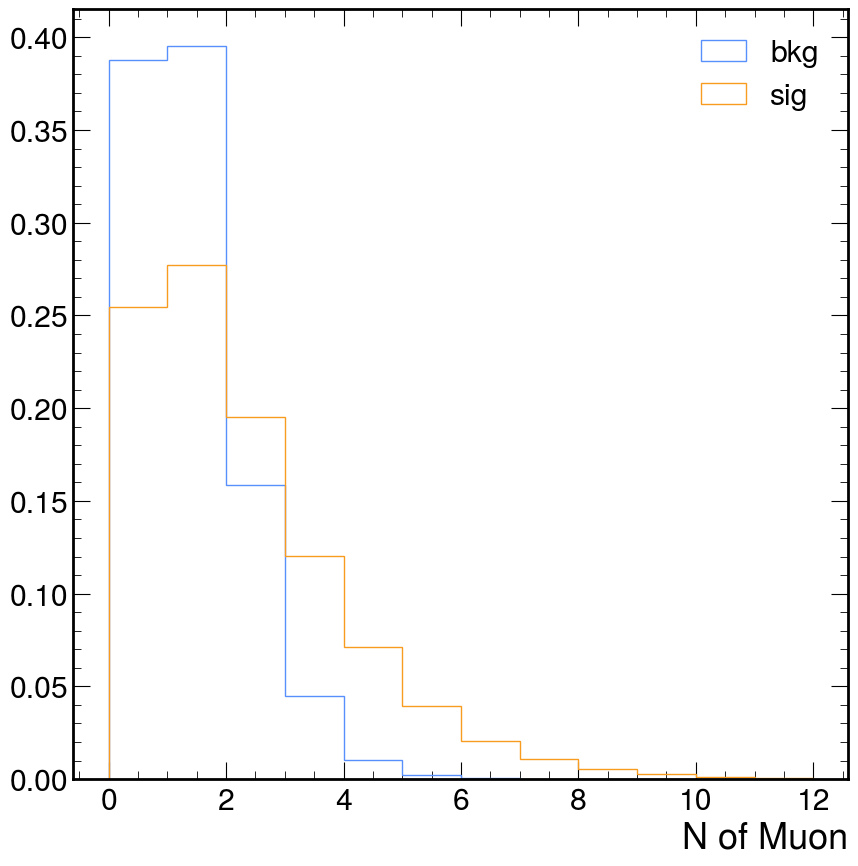

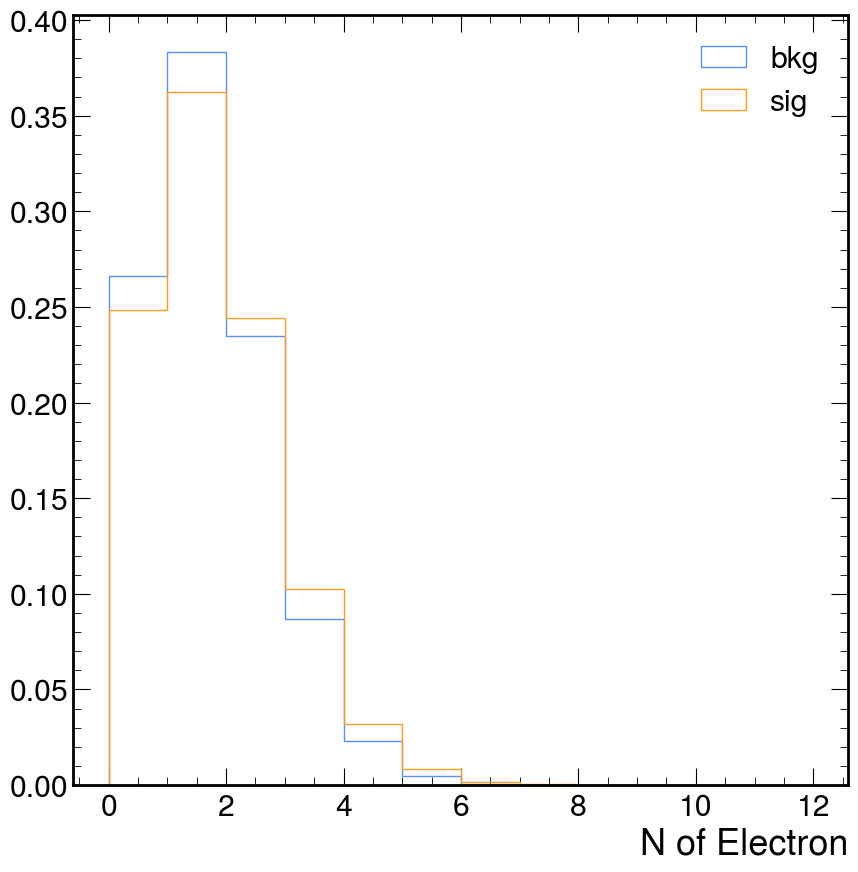

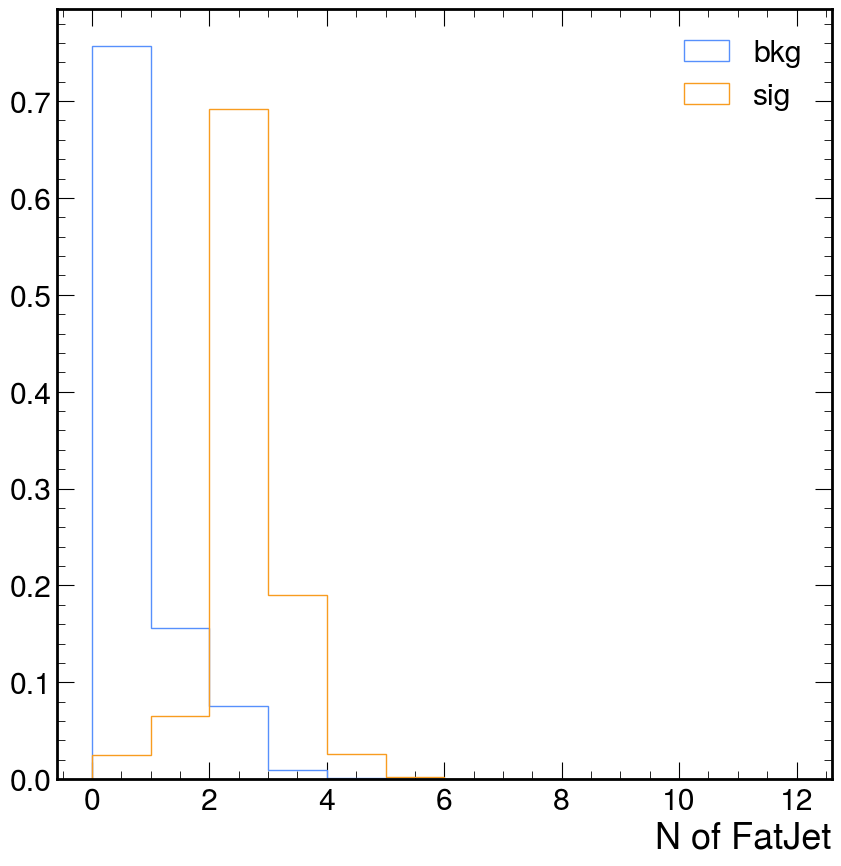

In [6]:
import mplhep
mplhep.style.use('CMS')

for obj in [ 'Muon', 'Electron', 'FatJet']:
    plt.figure()

     # Loop over background and signal datasets
    for label, data in zip(["bkg","sig"], [data_bkg, data_sig]):
        num = ak.num(data[obj])
        plt.hist(num, label = label, bins = range(13), density = True, 
                 histtype = "step")
        
    plt.xlabel(f"N of {obj}")
    plt.legend()

    plt.savefig(f'{obj}_histogram.png') 

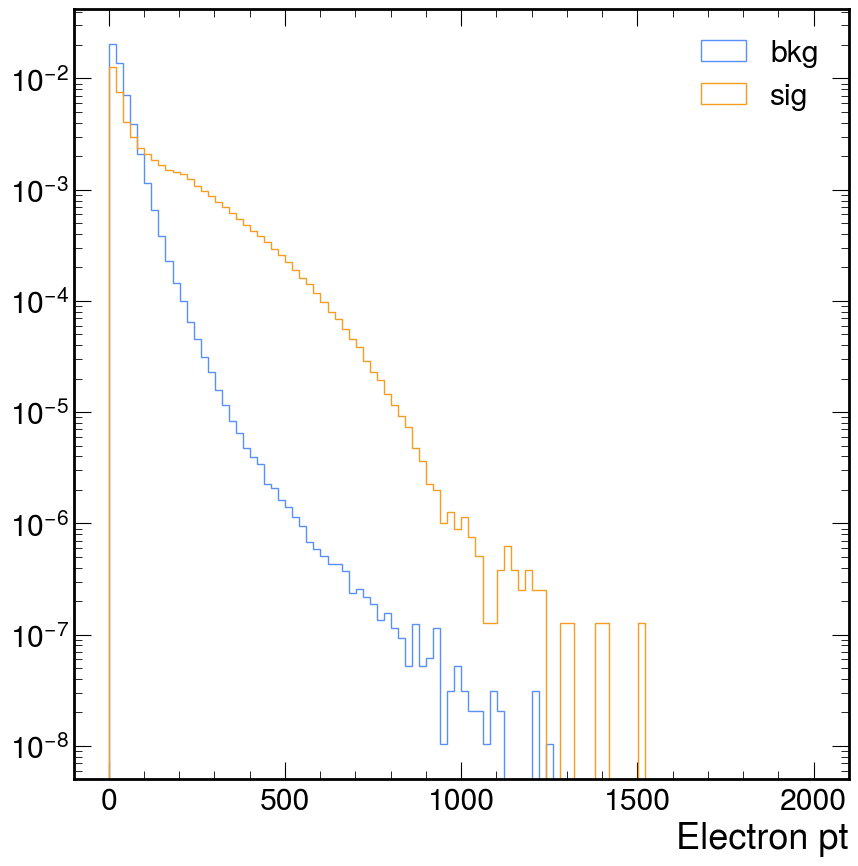

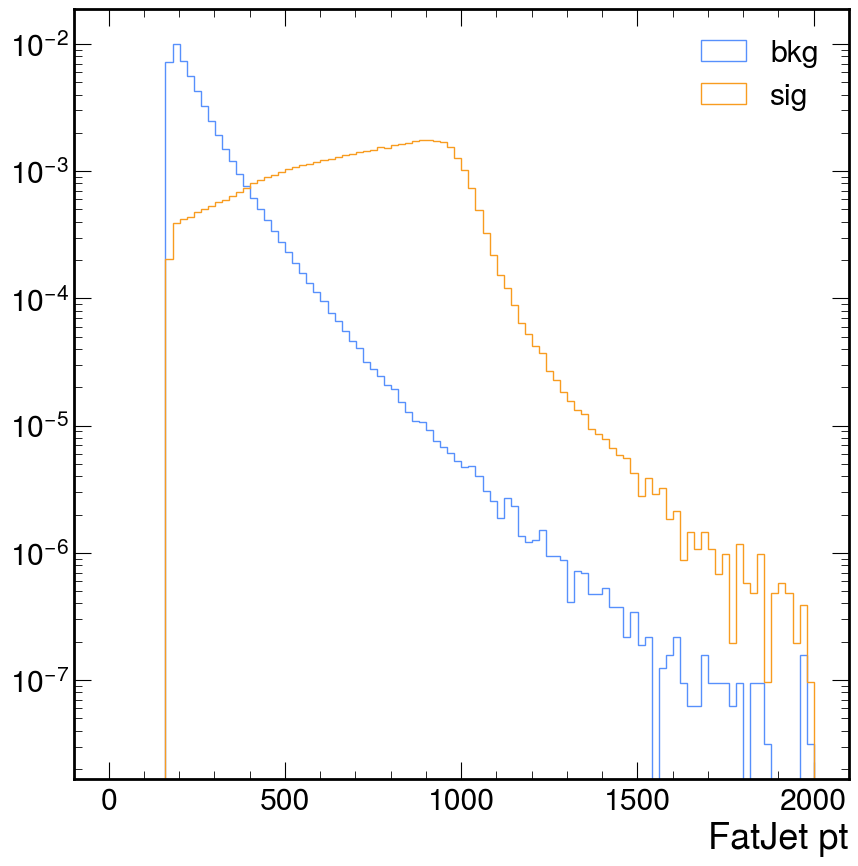

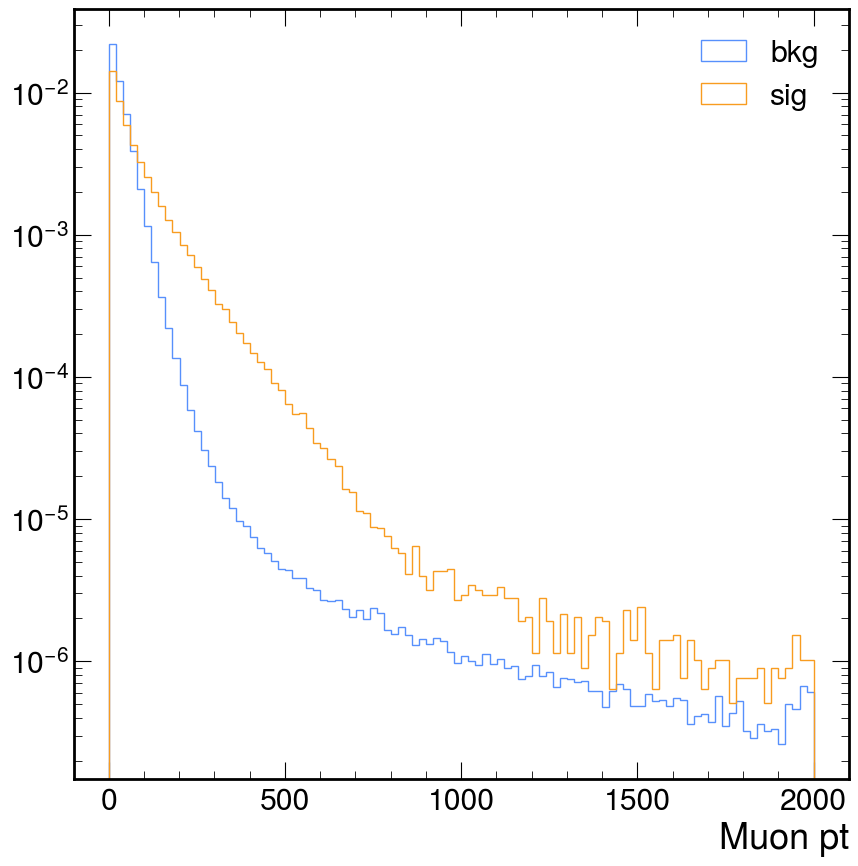

In [7]:
 for obj in [ 'Electron', 'FatJet', 'Muon']:
    plt.figure()

    # Loop over background and signal datasets
    for label, data in zip(["bkg","sig"], [data_bkg, data_sig]):
        # Flatten the array of transverse momenta (pt) and plot histogram
        plt.hist(ak.ravel(data[obj].pt[:,:1]), 
                 label = label, 
                 bins = np.linspace(1, 2000, 101), 
                 density = True, 
                 log = True, 
                 histtype = "step")
        
    plt.xlabel(f"{obj} pt")
    plt.legend()
     
    plt.savefig(f'{obj}_pt_histogram.png')

### Convert data to regular array for ML usage

In [8]:
def getPadNParr(events, obj, n_pad, fields, cuts = None, name = None, pad_val = 0):
    '''
    This function filter objects and pads them to a certain length with a given value
    '''
    
    objects = events[obj]
    
    if not name: name = obj
    
    pad_arrs = []
    var_names = []
        
    # padding with nones
    pad_arr = ak.pad_none(objects, n_pad, clip=True)
    
    # combining to numpy
    for i in range(n_pad):

        for var in fields:
            pad_arrs += [ak.to_numpy( ak.fill_none(pad_arr[var][:,i], pad_val) )]
            var_names.append( "{}_{}_{}".format(name, i, var) )
            
    return np.stack(pad_arrs), var_names

def formatData(data, objects, verbosity = 0):
    '''
    This function concatenates the padded arrays for different objects.
    It is controlled via a dictionary as defined above
    '''
    
    # this will be filled by all required objects
    dataList = [] 
    varList = []
    
    for obj in objects: 
        print(obj)
        dat, names = getPadNParr(data, obj["key"], obj["n_obj"], obj["fields"], obj["cuts"] if "cuts" in obj else None, obj["name"] )
        dataList.append(dat)
        varList += names
        
    if verbosity > 0:
        print("The input variables are the following:")
        print(varList)
                
    # combining and returning (and transforming back so events are along the first axis...)
    return np.concatenate(dataList, axis = 0).T, varList

In [9]:
 objects = [
    {"name" : "FatJet", "key" : "FatJet", "fields" : ["pt", "eta", "phi"], "n_obj" : 6},
    {"name" : "Electron", "key" : "Electron", "fields" : ["pt", "eta", "phi"], "n_obj" : 4},
    {"name" : "Muon", "key" : "Muon", "fields" : ["pt", "eta", "phi"], "n_obj" : 4}
]
    
x_sig, var_names = formatData(data_sig, objects, verbosity = 99) 
x_bkg, var_names = formatData(data_bkg, objects, verbosity = 0) 

{'name': 'FatJet', 'key': 'FatJet', 'fields': ['pt', 'eta', 'phi'], 'n_obj': 6}
{'name': 'Electron', 'key': 'Electron', 'fields': ['pt', 'eta', 'phi'], 'n_obj': 4}
{'name': 'Muon', 'key': 'Muon', 'fields': ['pt', 'eta', 'phi'], 'n_obj': 4}
The input variables are the following:
['FatJet_0_pt', 'FatJet_0_eta', 'FatJet_0_phi', 'FatJet_1_pt', 'FatJet_1_eta', 'FatJet_1_phi', 'FatJet_2_pt', 'FatJet_2_eta', 'FatJet_2_phi', 'FatJet_3_pt', 'FatJet_3_eta', 'FatJet_3_phi', 'FatJet_4_pt', 'FatJet_4_eta', 'FatJet_4_phi', 'FatJet_5_pt', 'FatJet_5_eta', 'FatJet_5_phi', 'Electron_0_pt', 'Electron_0_eta', 'Electron_0_phi', 'Electron_1_pt', 'Electron_1_eta', 'Electron_1_phi', 'Electron_2_pt', 'Electron_2_eta', 'Electron_2_phi', 'Electron_3_pt', 'Electron_3_eta', 'Electron_3_phi', 'Muon_0_pt', 'Muon_0_eta', 'Muon_0_phi', 'Muon_1_pt', 'Muon_1_eta', 'Muon_1_phi', 'Muon_2_pt', 'Muon_2_eta', 'Muon_2_phi', 'Muon_3_pt', 'Muon_3_eta', 'Muon_3_phi']
{'name': 'FatJet', 'key': 'FatJet', 'fields': ['pt', 'eta', 'p

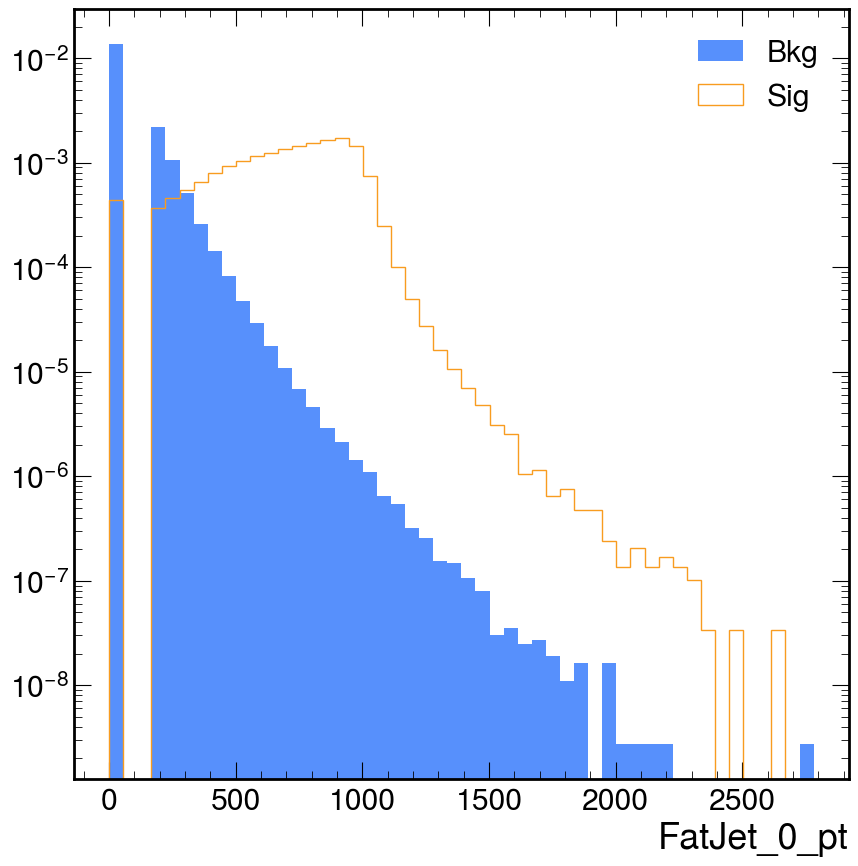

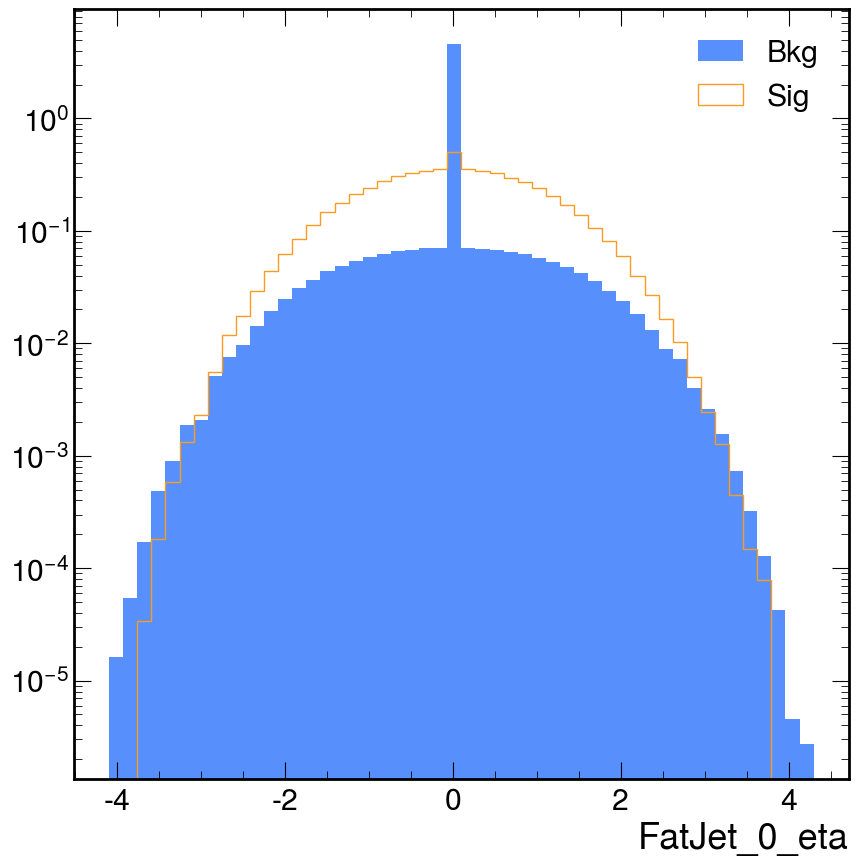

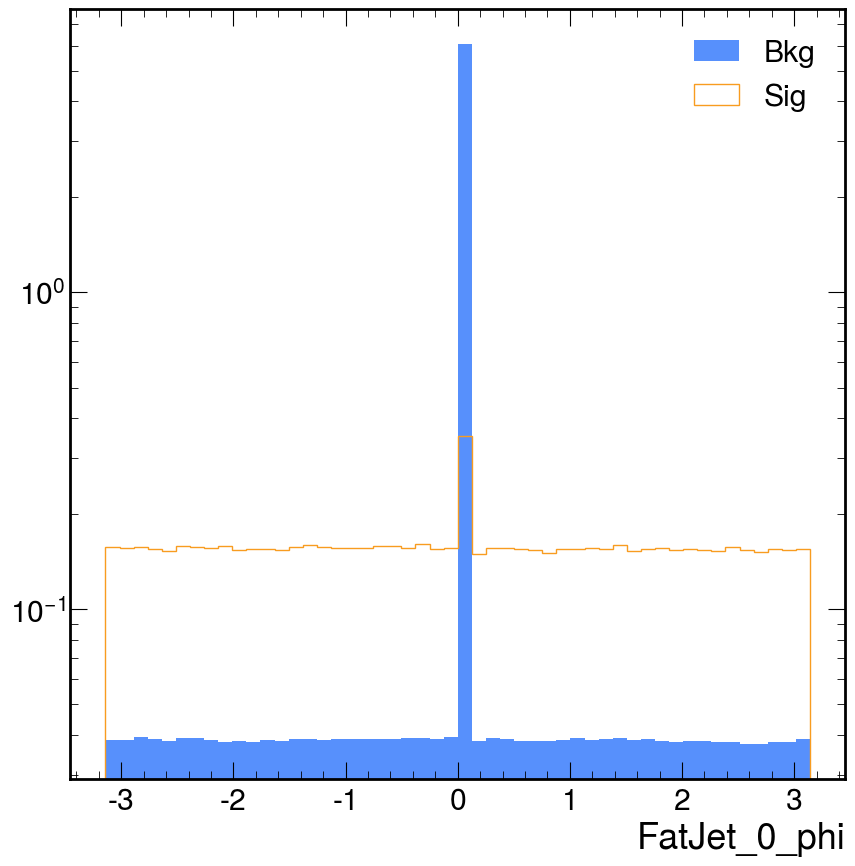

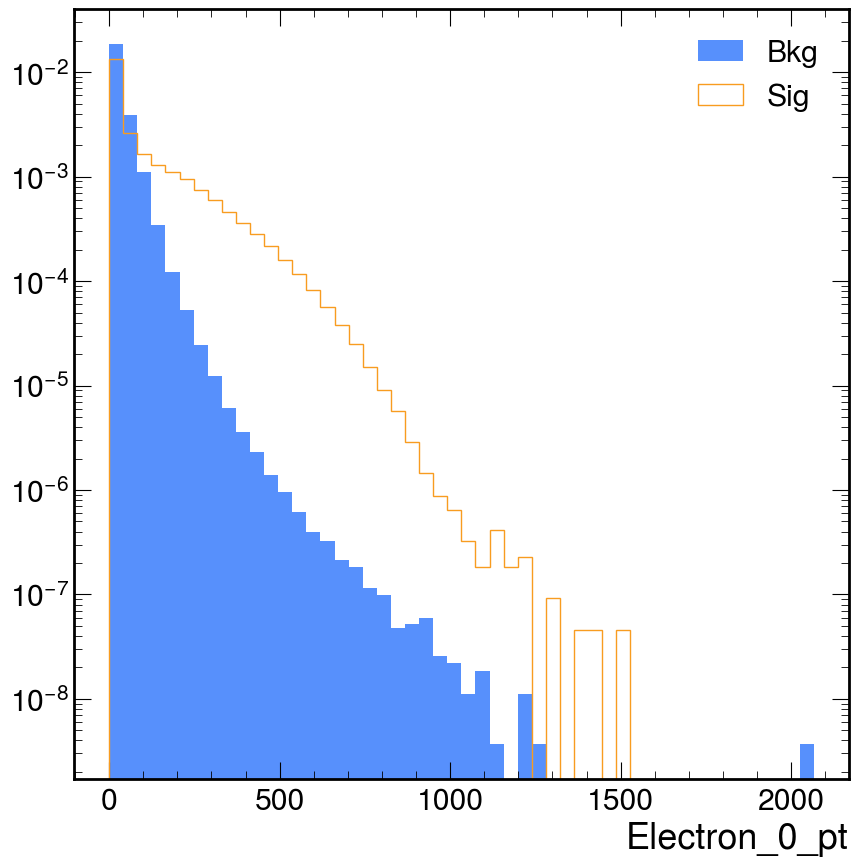

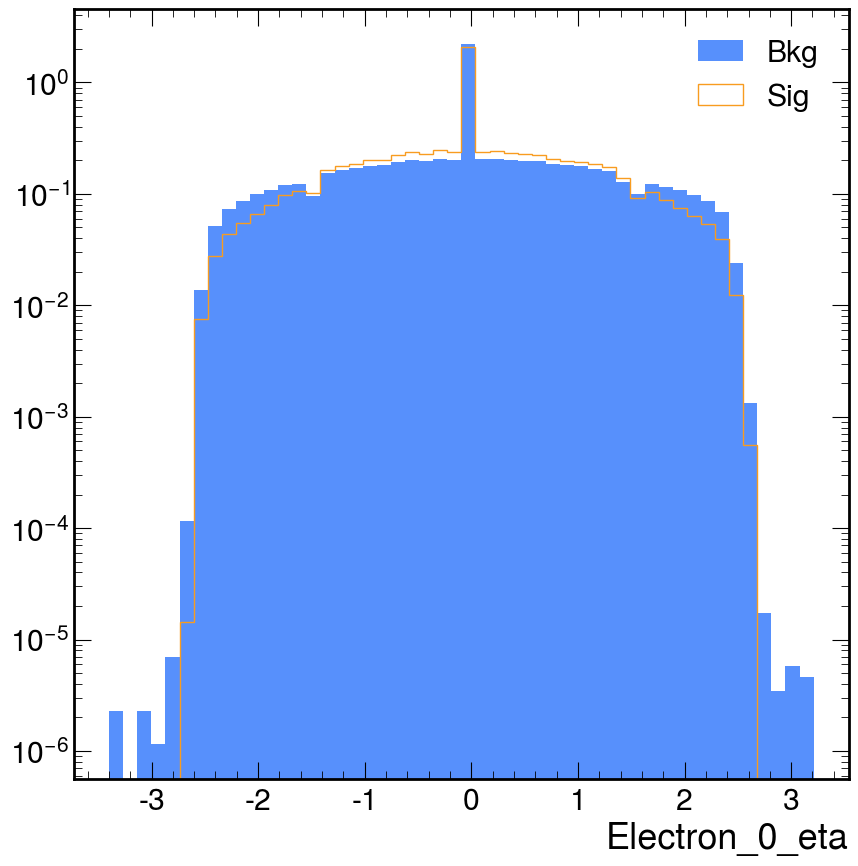

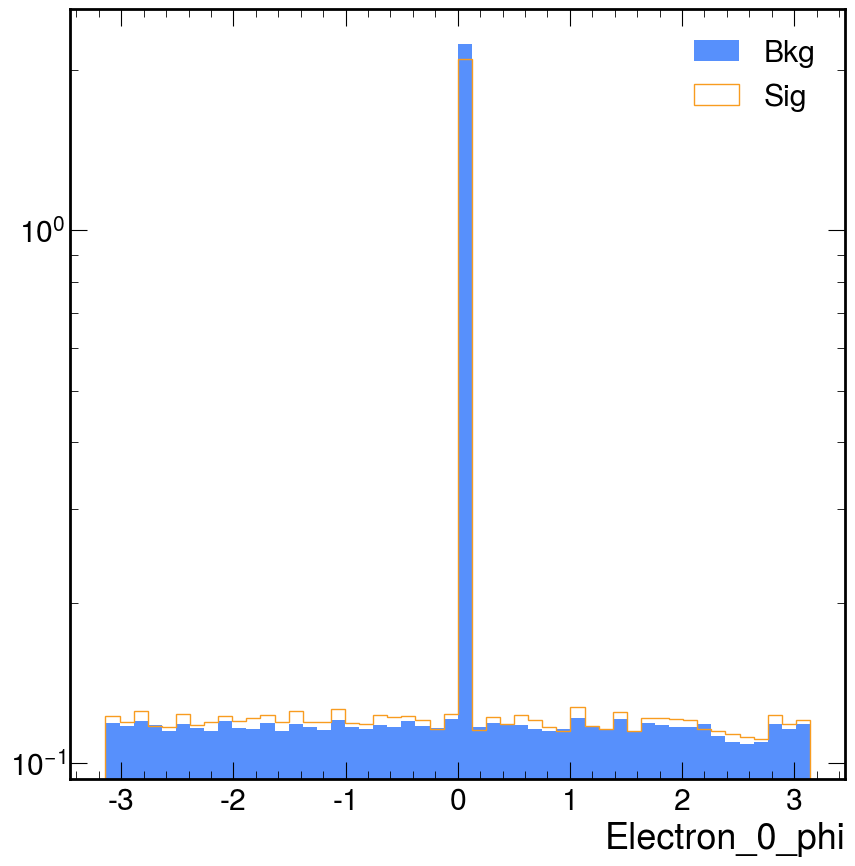

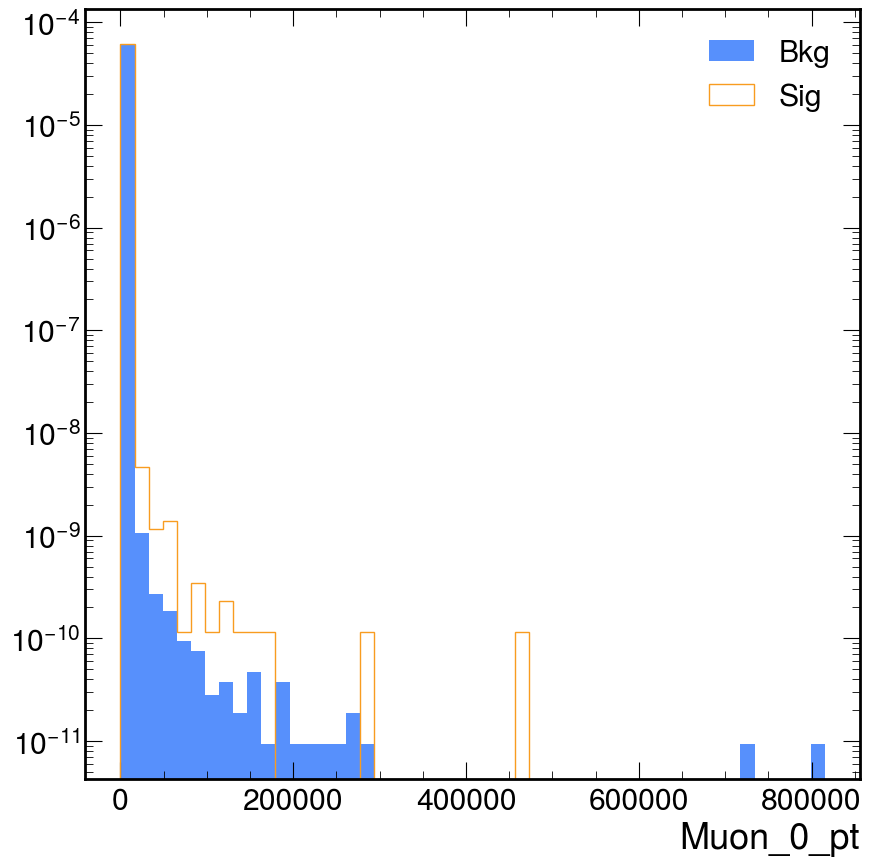

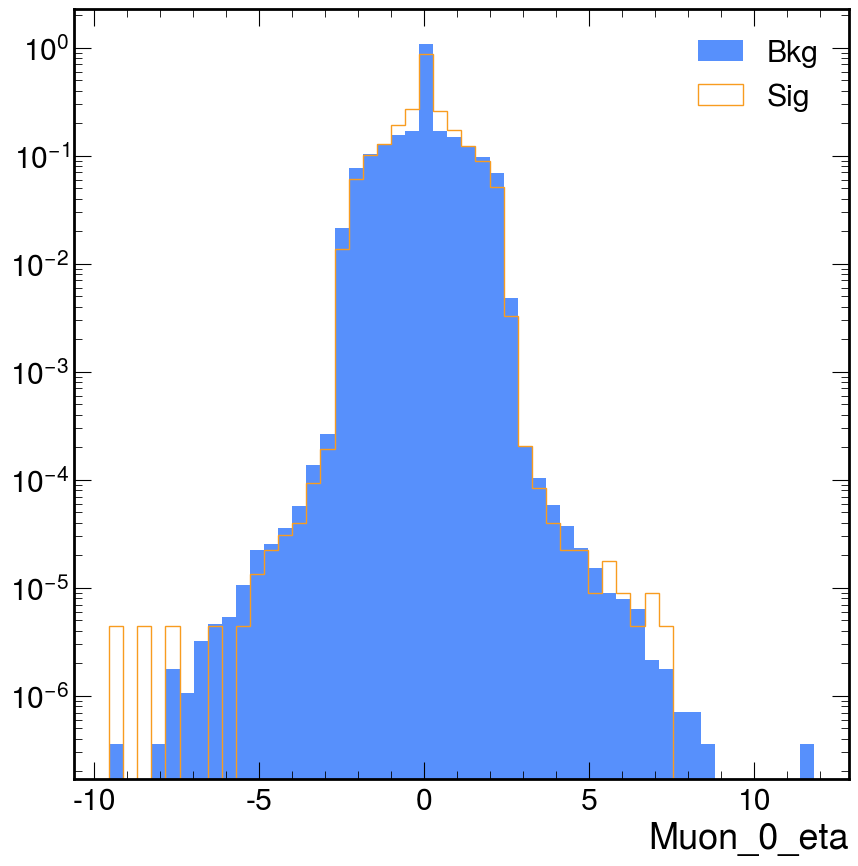

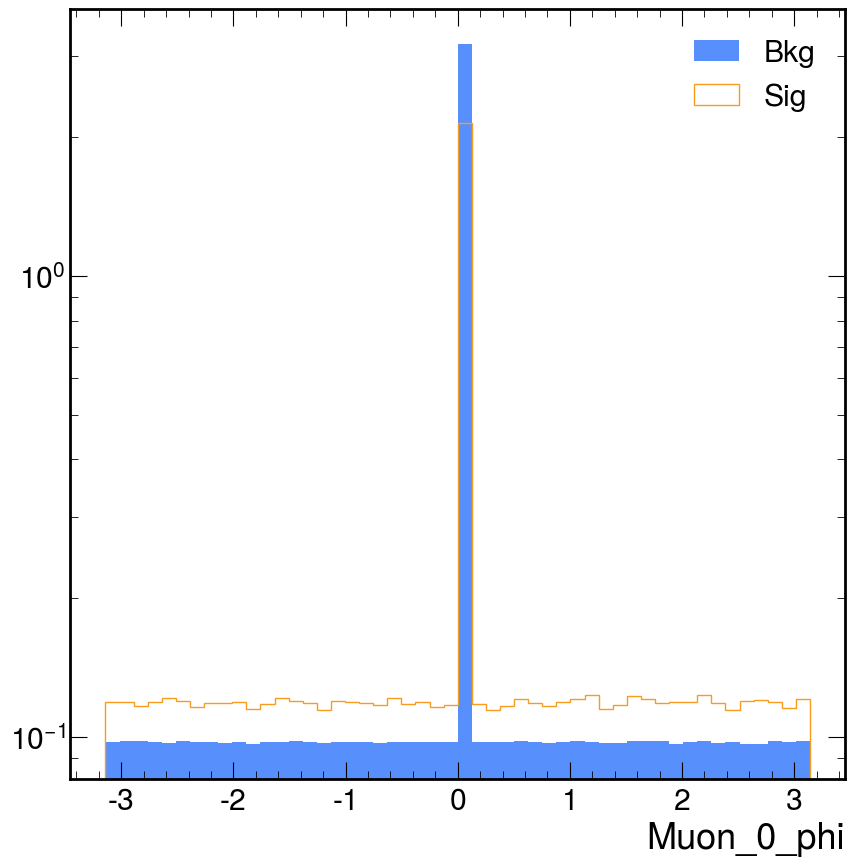

In [10]:
for i,name in enumerate(var_names[:100]):
    if "_0_" not in name: continue
        
    plt.figure()
    
    _ = plt.hist(x_bkg[:,i], bins = 50, log = True, density = True, label = "Bkg")
    _ = plt.hist(x_sig[:,i], bins = _[1], histtype = "step", density = True, label = "Sig")
    
    plt.xlabel(name)
    plt.legend()

### Final preprocessing

Having very different numerical ranges for input features, such as $p_T$, $\eta$, and $\phi$ with varying means, complicates network convergence. Standardization of $p_T$ will address this issue. Additionally, zero padding will be applied when no lepton is present in the event, resulting in an unnatural number of zero entries in $p_T$. For practical use cases, the loss function should be adapted to ignore zero entries. Addressing the periodicity of $\phi$ and other features is also ideal. Details on the preprocessing procedure can be found in [this paper](https://arxiv.org/abs/2108.03986).

Furthermore, the training data will be split into train/test sets and saved.

In [11]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
_ = scaler.fit(x_bkg)
x_bkg_scaled = scaler.transform(x_bkg)
x_sig_scaled = scaler.transform(x_sig)
    
        
# define training, test and validation datasets
X_train, X_test = train_test_split(x_bkg_scaled, test_size=0.2, shuffle=True)

print("Training data shape = ",X_train.shape)    
with h5py.File('bkg_dataset.h5', 'w') as h5f:
    h5f.create_dataset('X_train', data = X_train)
    h5f.create_dataset('X_test', data = X_test)
    
with h5py.File('signal_dataset.h5', 'w') as h5f2:
    h5f2.create_dataset('Data', data = x_sig_scaled)        

Training data shape =  (5252000, 42)


Inspecting the training data:

In [12]:
with h5py.File('bkg_dataset.h5', 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    
with h5py.File('signal_dataset.h5', 'r') as file:
    signal_test_data = np.array(file['Data'])

 Training (#samples,#features): (5252000, 42)
 Testing  (#samples,#features): (527279, 42)
Example data (1,57): [ 2.63425238e+00 -2.91820331e+00  1.10927996e+00  3.86002590e+00
 -1.33195883e+00  4.02752708e+00  1.24992985e+01  1.47956036e+00
 -7.74794842e+00 -3.55355610e-02 -8.20719786e-04  3.38541077e-04
 -1.04825004e-02  2.51406071e-04 -3.71710362e-04 -2.50621845e-03
 -3.10081644e-04  7.53745095e-04  3.54414297e+00  2.03029516e-01
 -1.14976226e+00  4.70999157e+00 -8.54743231e-01  2.07748126e+00
 -2.93701597e-01 -7.23386244e-03  3.41942421e-03 -1.52276549e-01
 -4.79915282e-03  2.77065972e-03  3.19357056e-01 -1.85587237e+00
  6.19174360e-01  6.04498030e-01 -3.01483801e+00  1.46366324e+00
 -1.76382229e-01 -9.70678578e-04  2.76996464e-04 -8.63866533e-02
 -8.31566617e-04  2.02735528e-04]


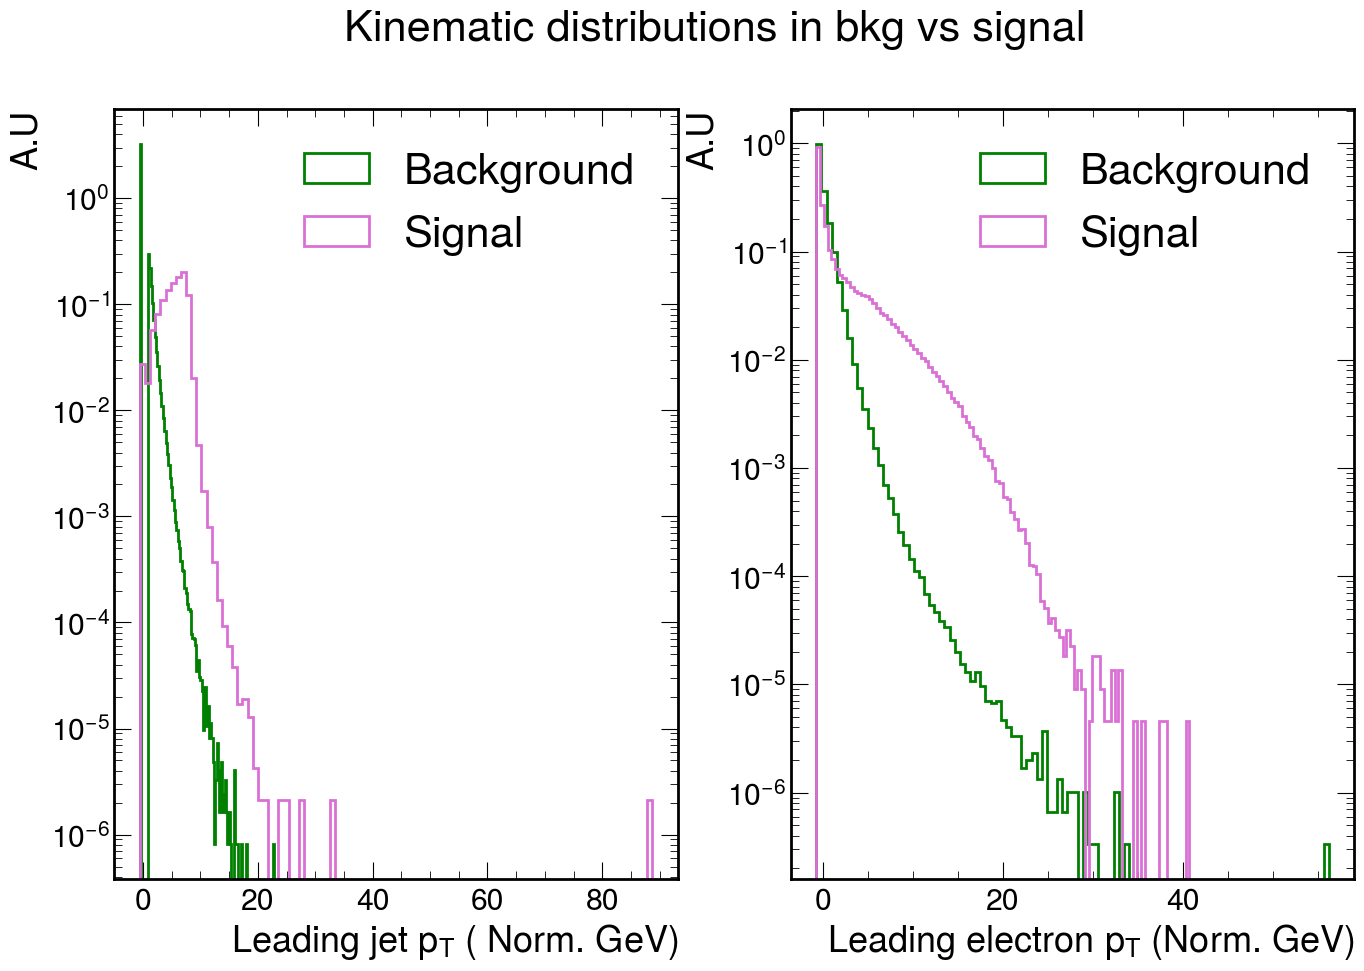

In [13]:
print(" Training (#samples,#features):", X_train.shape)
print(" Testing  (#samples,#features):", signal_test_data.shape)

fig, axs = plt.subplots(1,2,figsize=(16,10))
fig.suptitle('Kinematic distributions in bkg vs signal')

axs[0].hist(X_train[:,0],bins=100,label=r'Background',histtype='step', linewidth=2, facecolor='none', edgecolor='green',fill=True,density=True)
axs[0].hist(signal_test_data[:,0 ],bins=100,label=r'Signal',histtype='step', linewidth=2, facecolor='none', edgecolor='orchid',fill=True,density=True)
axs[0].semilogy()
axs[0].set(xlabel=u'Leading jet $p_{T}$ ( Norm. GeV)', ylabel='A.U')
axs[0].legend(loc='best',frameon=False, ncol=1,fontsize='large')

axs[1].hist(X_train[:,18],bins=100,label=r'Background',histtype='step', linewidth=2, facecolor='none', edgecolor='green',fill=True,density=True)
axs[1].hist(signal_test_data[:,18],bins=100,label=r'Signal',histtype='step', linewidth=2, facecolor='none', edgecolor='orchid',fill=True,density=True)
axs[1].set(xlabel=u'Leading electron $p_{T}$ (Norm. GeV)', ylabel='A.U')
axs[1].semilogy()
axs[1].legend(loc='best',frameon=False, ncol=1,fontsize='large')
print("Example data (1,57):",signal_test_data[3])

### Defining the autoencoder

Defining an autoencoder involves learning to reconstruct the training data after compressing it through a bottleneck and then decompressing it. A stack of dense layers is required for this purpose.

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Activation, Concatenate, Dropout, Layer
from tensorflow.keras.layers import ReLU, LeakyReLU

input_shape = X_train.shape[1]
latent_dim = 3
#encoder
inputArray = Input(shape=(input_shape,))
#x = BatchNormalization()(inputArray) #Only use this if you're not standardizing the pT
x = Dense(32, kernel_initializer=tf.keras.initializers.HeUniform())(inputArray)
x = BatchNormalization()(x) 
x = LeakyReLU(alpha=0.3)(x)
x = Dense(16, kernel_initializer=tf.keras.initializers.HeUniform())(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
encoder = Dense(latent_dim, kernel_initializer=tf.keras.initializers.HeUniform())(x)

#decoder
x = Dense(16, kernel_initializer=tf.keras.initializers.HeUniform())(encoder)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
x = Dense(32, kernel_initializer=tf.keras.initializers.HeUniform())(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
decoder = Dense(input_shape, kernel_initializer=tf.keras.initializers.HeUniform())(x)

#create autoencoder
autoencoder = Model(inputs = inputArray, outputs=decoder)
autoencoder.summary()

2024-08-19 22:07:18.656152: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 22:07:19.346685: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/acer/Pythia8/lib:/usr/local/openssl/lib:/home/acer/root/lib::/home/acer/root/lib:/home/acer/lhapdf_installation/lib
2024-08-19 22:07:19.346707: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-08-19 22:07:23.391962: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 42)]              0         
                                                                 
 dense (Dense)               (None, 32)                1376      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                             

In [15]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='mse')

### Let's train!

In [16]:
train = True 
EPOCHS = 150
BATCH_SIZE = 1024

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

callbacks=[]
callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6))
callbacks.append(TerminateOnNaN())
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=10, restore_best_weights=True))

if train:
    history = autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
              validation_split=0.2,
              callbacks=callbacks)
    # Save the model
    autoencoder.save('baseline_ae.h5')
    autoencoder.save_weights('baseline_ae.weights.h5')
    
else:
    autoencoder = tf.keras.models.load_model('baseline_ae.h5')

2024-08-19 22:07:27.079955: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 705868800 exceeds 10% of free system memory.
2024-08-19 22:07:28.331669: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 705868800 exceeds 10% of free system memory.


Epoch 1/150
4104/4104 [==============================] - 33s 7ms/step - loss: 1.6738 - val_loss: 1.2183 - lr: 1.0000e-05
Epoch 2/150
4104/4104 [==============================] - 24s 6ms/step - loss: 1.0686 - val_loss: 0.9186 - lr: 1.0000e-05
Epoch 3/150
4104/4104 [==============================] - 26s 6ms/step - loss: 0.9251 - val_loss: 0.8565 - lr: 1.0000e-05
Epoch 4/150
4104/4104 [==============================] - 26s 6ms/step - loss: 0.8805 - val_loss: 0.8253 - lr: 1.0000e-05
Epoch 5/150
4104/4104 [==============================] - 24s 6ms/step - loss: 0.8551 - val_loss: 0.8040 - lr: 1.0000e-05
Epoch 6/150
4104/4104 [==============================] - 25s 6ms/step - loss: 0.8371 - val_loss: 0.7886 - lr: 1.0000e-05
Epoch 7/150
4104/4104 [==============================] - 27s 7ms/step - loss: 0.8236 - val_loss: 0.7747 - lr: 1.0000e-05
Epoch 8/150
4104/4104 [==============================] - 36s 9ms/step - loss: 0.8129 - val_loss: 0.7651 - lr: 1.0000e-05
Epoch 9/150
4104/4104 [=========

### Evaluating the model performance

The key metric for anomaly detection is the mean-squared-error: a high error indicates a higher likelihood of data being anomalous, while a low error suggests similarity to the training data (in this case, SM events). Therefore, `model.predict()` must be run first to obtain the AE reconstructed output for both the SM test data and the new signal.

In [17]:
bkg_prediction = autoencoder.predict(X_test)
signal_prediction = autoencoder.predict(signal_test_data)

2024-08-19 23:01:55.306401: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 220584000 exceeds 10% of free system memory.


41032/41032 [==============================] - 47s 1ms/step


2024-08-19 23:03:03.404323: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 220584000 exceeds 10% of free system memory.


16478/16478 [==============================] - 19s 1ms/step


Let's see how well the network reconstructs the transverse momentum of the leptons:

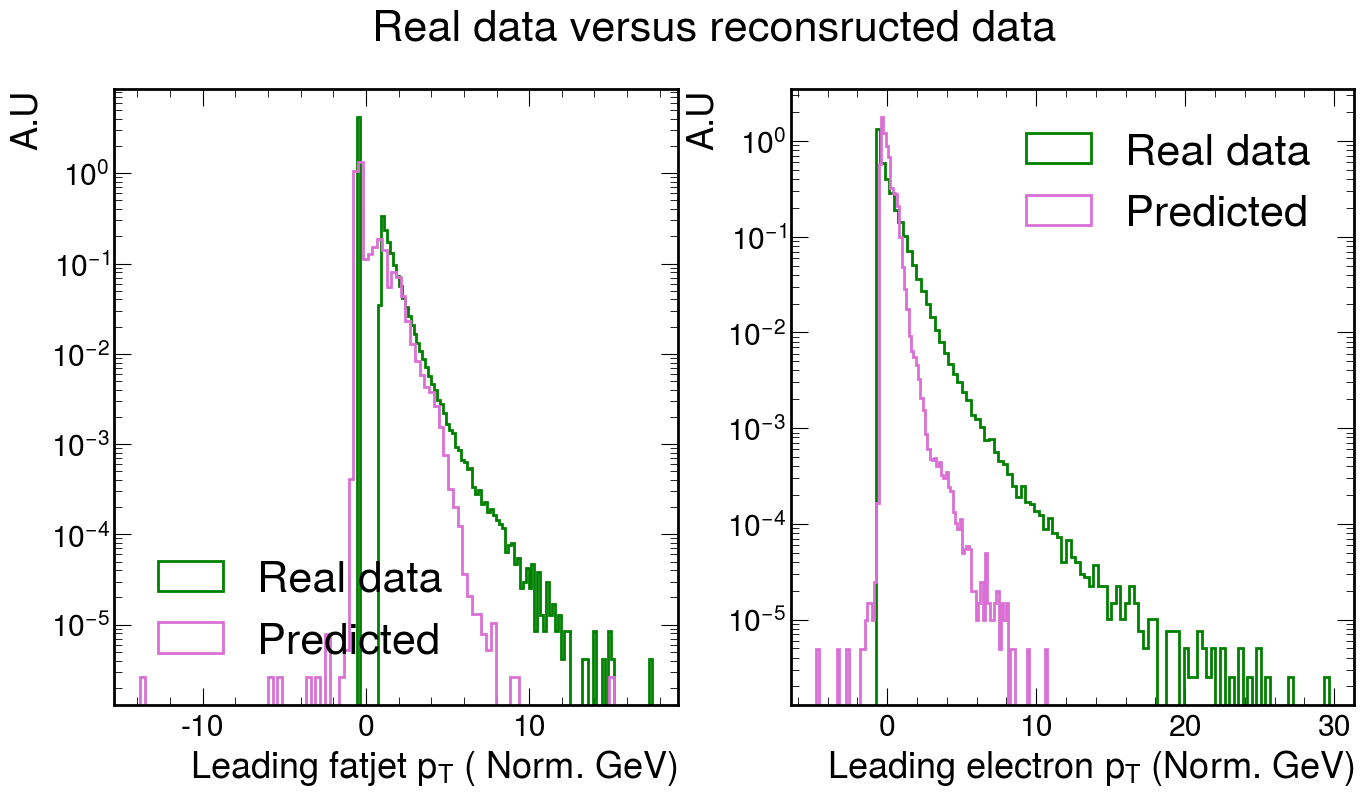

In [18]:
fig, axs = plt.subplots(1,2,figsize=(16,8))
fig.suptitle('Real data versus reconsructed data')
axs[0].hist(X_test[:,0],bins=100,label=r'Real data',histtype='step', linewidth=2, facecolor='none', edgecolor='green',fill=True,density=True)
axs[0].hist(bkg_prediction[:,0],bins=100,label=r'Predicted',histtype='step', linewidth=2, facecolor='none', edgecolor='orchid',fill=True,density=True)
axs[0].semilogy()
axs[0].set(xlabel=u'Leading fatjet $p_{T}$ ( Norm. GeV)', ylabel='A.U')
axs[0].legend(loc='best',frameon=False, ncol=1,fontsize='large')

axs[1].hist(X_test[:,18],bins=100,label=r'Real data',histtype='step', linewidth=2, facecolor='none', edgecolor='green',fill=True,density=True)
axs[1].hist(bkg_prediction[:,18],bins=100,label=r'Predicted',histtype='step', linewidth=2, facecolor='none', edgecolor='orchid',fill=True,density=True)
axs[1].set(xlabel=u'Leading electron $p_{T}$ (Norm. GeV)', ylabel='A.U')
axs[1].semilogy()
axs[1].legend(loc='best',frameon=False, ncol=1,fontsize='large')

plt.savefig('real_vs_reconstructed_data.png', format='png', dpi=300)

plt.show()

The mean-square-error must then be computed, serving as the final discriminating variable.

In [19]:
def mse_loss(true, prediction):
    loss = tf.reduce_mean(tf.math.square(true - prediction),axis=-1)
    return loss

# compute loss value of input data versus AE reconstructed data
mse_sm = mse_loss(X_test, bkg_prediction.astype(np.float32)).numpy()
mse_bsm = mse_loss(signal_test_data,signal_prediction.astype(np.float32)).numpy()

2024-08-19 23:03:34.592084: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 441168000 exceeds 10% of free system memory.


The mean squared error (MSE) analysis is performed to quantify the difference between the real data and the reconstructed data. It is expected that the MSE for the anomalous signal will be higher, indicating that anomalous events are less well reconstructed by the model, as the autoencoder is trained exclusively with background data.

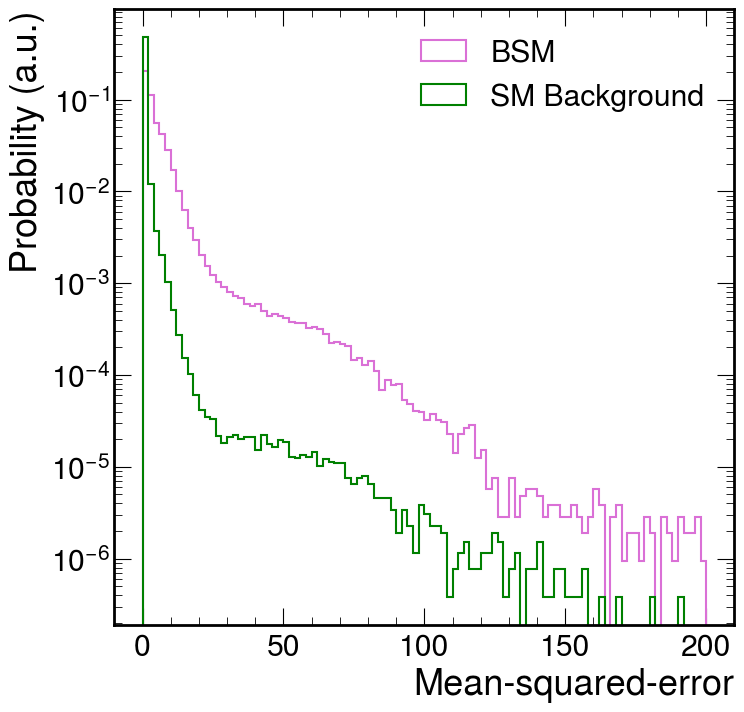

In [20]:
bin_size=100

plt.figure(figsize=(8,8))
n, bins, patches =plt.hist(mse_bsm, bins=bin_size, label="BSM", density = True, histtype='step', fill=False, edgecolor='orchid', linewidth=1.5,range=[0,200])
n_, bins_, patches_ =plt.hist(mse_sm, bins=bin_size, label="SM Background", density = True, histtype='step', fill=False, edgecolor='green', linewidth=1.5,range=[0,200])
plt.yscale('log')
plt.xlabel("Mean-squared-error")
plt.ylabel("Probability (a.u.)")
plt.legend(loc='best')

plt.savefig("mse_distribution.png", format='png', dpi=300)

plt.show()

The results show that the MSE for the anomalous signal (BSM) is, on average, higher than for the background, as expected. This confirms that the autoencoder has more difficulty reconstructing Z' signal events, suggesting that these events are recognized as anomalous. The green line in the graph indicates that the MSE for the background is lower, confirming that the model reconstructs well the data it was trained on.

The difference in MSE distributions between the background and the Z' signal demonstrates that the autoencoder is effective in identifying anomalies. The higher probability of elevated MSE for the anomalous signal suggests that these events are significantly different from the background events (Standard Model events).

The ROC curve is constructed by comparing the MSE distributions for normal data (SM) and anomalous data (BSM). This curve reflects the model's ability to correctly identify anomalous events based on an MSE threshold and the fraction of normal events incorrectly classified as anomalous.

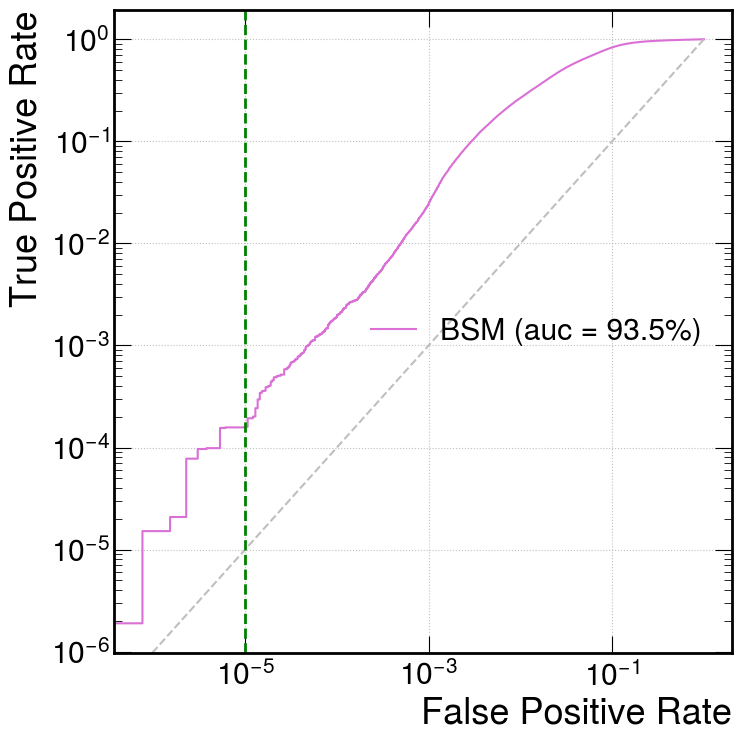

In [21]:
from sklearn.metrics import roc_curve, auc

target_background = np.zeros(mse_sm.shape[0])

plt.figure(figsize=(8,8))
trueVal = np.concatenate((np.ones(mse_bsm.shape[0]), target_background)) # anomaly=1, bkg=0
predVal_loss = np.concatenate((mse_bsm, mse_sm))

fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

auc_loss = auc(fpr_loss, tpr_loss)
    
plt.plot(fpr_loss, tpr_loss, "-", label='BSM (auc = %.1f%%)'%(auc_loss*100.), linewidth=1.5, color = "orchid")
    
plt.semilogx()
plt.semilogy()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc='center right')
plt.grid(True)
plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='green', linestyle='dashed', linewidth=2) # threshold value for measuring anomaly detection efficiency

plt.savefig('roc_curve_plot.png') 

plt.show()

The ROC curve result is 93.5%, indicating a high capacity of the model to effectively identify anomalies. The ROC curve, which approaches the upper left corner of the graph, suggests a good separation between the two classes and a high AUC, confirming the effectiveness of the autoencoder in detecting anomalies.

### Quantization aware training with QKeras

Quantization is a powerful method for reducing model memory and resource consumption. For this purpose, the QKeras library will be used to perform quantization-aware training (QAT).

Unlike in Keras, where models are trained using floating-point precision, QKeras quantizes each model weight and activation function during training. This allows the network to adapt to the numerical precision that will eventually be used on hardware.

### Translating to a QKeras QAT model
Two ways exist to translate this into a QKeras model for quantization-aware training. First, the manual approach will be used:

### Manual QKeras model definition:

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1

from tensorflow.keras.layers import Activation
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

input_shape = X_train.shape[1]
latent_dim = 3

#encoder
inputArray = Input(shape=(input_shape,))
# x = BatchNormalization()(inputArray)
x = QDense(32, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(8,3,1, alpha=1.0)',
               bias_quantizer='quantized_bits(8,3,1, alpha=1.0)')(inputArray)
x = BatchNormalization()(x)
x = QActivation('quantized_relu(bits=8)')(x)
x = QDense(16, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(8,3,1, alpha=1.0)',
               bias_quantizer='quantized_bits(8,3,1, alpha=1.0)')(x)
x = BatchNormalization()(x)
x = QActivation('quantized_relu(bits=8)')(x)
encoder = QDense(latent_dim, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(16,6,1, alpha=1.0)',
               bias_quantizer='quantized_bits(16,6,1, alpha=1.0)', name='bottleneck')(x)

#decoder
x = QDense(16, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(8,3,1, alpha=1.0)',
               bias_quantizer='quantized_bits(8,3,1, alpha=1.0)')(encoder)
x = BatchNormalization()(x)
x = QActivation('quantized_relu(bits=8)')(x)
x = QDense(32, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(8,3,1, alpha=1.0)',
               bias_quantizer='quantized_bits(8,3,1, alpha=1.0)')(x)
x = BatchNormalization()(x)
x = QActivation('quantized_relu(bits=8)')(x)
decoder = QDense(input_shape, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(16,6,1, alpha=1.0)',
               bias_quantizer='quantized_bits(16,6,1, alpha=1.0)')(x)

#create autoencoder
q_autoencoder = Model(inputs = inputArray, outputs=decoder)
q_autoencoder.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 42)]              0         
                                                                 
 q_dense (QDense)            (None, 32)                1376      
                                                                 
 batch_normalization_4 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 q_activation (QActivation)  (None, 32)                0         
                                                                 
 q_dense_1 (QDense)          (None, 16)                5

- `bits`: Determines the bitwidth, allowing for $2^{bits}$ unique values for each weight parameter.
- `integers`: Specifies the number of integer bits; in this case, zero. All 8 bits are used to represent the fractional part of the weight parameter, with no bits dedicated to whole numbers. This restricts the value to between -1 and 1. For DNNs, this approach focuses on the precision of the fraction rather than the magnitude of the number.
- `symmetric`: Indicates whether the values should be symmetric around 0; in this case, symmetry is not required.
- `alpha`: With $2^W$ unique values available, they could range from $[-2^W, 2^W-1]$ as previously mentioned, or from $[-2^W*\alpha, (2^W-1)*\alpha]$. `alpha` scales the weights. Enabling this often improves performance, but it may not integrate well with hls4ml.

Note that the sigmoid and final output logit are left unquantized to maintain accuracy and avoid significant resource savings from quantization in these layers.

### Automatic Model Quantization via Configuration
Quantization for the entire model can also be set through a model configuration. This method can be more convenient when using the same quantizer for all layers of the same type. Example:

In [23]:
autoQuant = False

if autoQuant:
    config = {
      "QDense": {
          "kernel_quantizer": "quantized_bits(bits=8, integer=0, symmetric=0, alpha=1)",
          "bias_quantizer": "quantized_bits(bits=8, integer=0, symmetric=0, alpha=1)",
      },
      "QActivation": { "relu": "quantized_relu(8)" }
    }
    from qkeras.utils import model_quantize

    qmodel = model_quantize(autoencoder, config, 4, transfer_weights=True)

    for layer in qmodel.layers:
        if hasattr(layer, "kernel_quantizer"):
            print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal))
        elif hasattr(layer, "quantizer"):
            print(layer.name, "quantizer:", str(layer.quantizer))

    print()
    qmodel.summary()

Be cautious to ensure that activation functions like softmax, sigmoid, and possibly logit layers, which should remain at full precision, do not get quantized.

### But how many bits?

Knowing how to quantize models is straightforward, but choosing the appropriate precision is less so. Finding the optimal number of bits and integer bits involves two recommended approaches:

- Scan through possible bit widths, from binary up to a maximum value, and select the smallest width that maintains acceptable accuracy.
- Utilize the library for automatic quantization, [AutoQKeras].

### Pruning

In addition to reducing the numerical precision of all weights, biases, and activations, removing neurons and synapses that contribute minimally to the overall network decision is also desired. Pruning is used for this purpose. Removing 50% of the weights (sparsity=0.5) can be performed as follows:

In [24]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

def pruneFunction(layer):
    pruning_params = {'pruning_schedule': pruning_schedule.PolynomialDecay(initial_sparsity=0.05,final_sparsity=0.50, begin_step=0, end_step=100, frequency=100)}
    if isinstance(layer, tf.keras.layers.Dense) and layer.name!='bottleneck':
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)  
    return layer

# q_autoencoder.load_weights('baseline_ae.weights.h5')
qp_autoencoder = tf.keras.models.clone_model( q_autoencoder, clone_function=pruneFunction)
qp_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='mse')

In [25]:
train = True
EPOCHS = 150
BATCH_SIZE = 1024

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

callbacks=[]
callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6))
callbacks.append(TerminateOnNaN())
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=10, restore_best_weights=False))
callbacks.append(pruning_callbacks.UpdatePruningStep())
if train:
        
    history = qp_autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_split=0.2,
                  callbacks=callbacks)
    # Save the model
    qp_autoencoder = strip_pruning(qp_autoencoder)
    qp_autoencoder.save('qkeras_ae.h5')
    
else:
    from qkeras.utils import _add_supported_quantized_objects
    co = {}; _add_supported_quantized_objects(co)

    qp_autoencoder = tf.keras.models.load_model('qkeras_ae.h5',custom_objects=co)
    

Epoch 1/150
4104/4104 [==============================] - 34s 7ms/step - loss: 1.2721 - val_loss: 1.1294 - lr: 1.0000e-05
Epoch 2/150
4104/4104 [==============================] - 28s 7ms/step - loss: 1.1109 - val_loss: 1.0147 - lr: 1.0000e-05
Epoch 3/150
4104/4104 [==============================] - 28s 7ms/step - loss: 1.0282 - val_loss: 0.9597 - lr: 1.0000e-05
Epoch 4/150
4104/4104 [==============================] - 28s 7ms/step - loss: 0.9874 - val_loss: 0.9313 - lr: 1.0000e-05
Epoch 5/150
4104/4104 [==============================] - 28s 7ms/step - loss: 0.9639 - val_loss: 0.9130 - lr: 1.0000e-05
Epoch 6/150
4104/4104 [==============================] - 28s 7ms/step - loss: 0.9484 - val_loss: 0.8995 - lr: 1.0000e-05
Epoch 7/150
4104/4104 [==============================] - 28s 7ms/step - loss: 0.9363 - val_loss: 0.8888 - lr: 1.0000e-05
Epoch 8/150
4104/4104 [==============================] - 28s 7ms/step - loss: 0.9266 - val_loss: 0.8795 - lr: 1.0000e-05
Epoch 9/150
4104/4104 [=========

Verify that the pruning worked and 50% of the weights are indeed zero.

Layer dense: % of zeros = 0.0
Layer dense_1: % of zeros = 0.0
Layer dense_2: % of zeros = 0.0
Layer dense_3: % of zeros = 0.0
Layer dense_4: % of zeros = 0.0
Layer dense_5: % of zeros = 0.0
Layer q_dense: % of zeros = 0.5
Layer q_dense_1: % of zeros = 0.5
Layer bottleneck: % of zeros = 0.0
Layer q_dense_2: % of zeros = 0.5
Layer q_dense_3: % of zeros = 0.5
Layer q_dense_4: % of zeros = 0.5


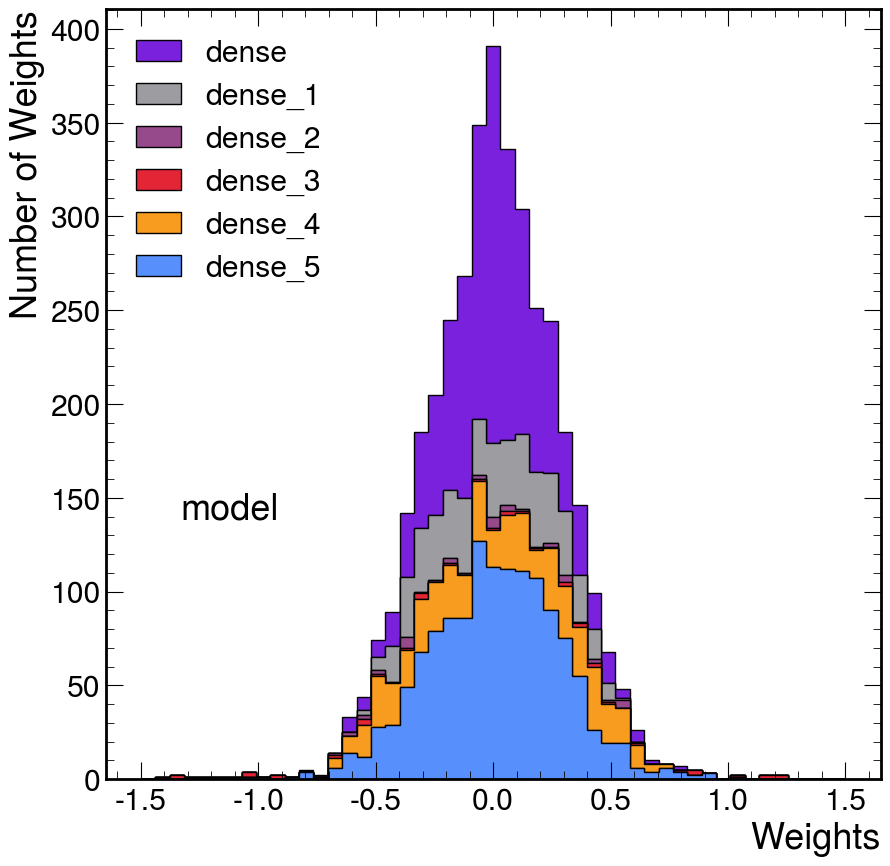

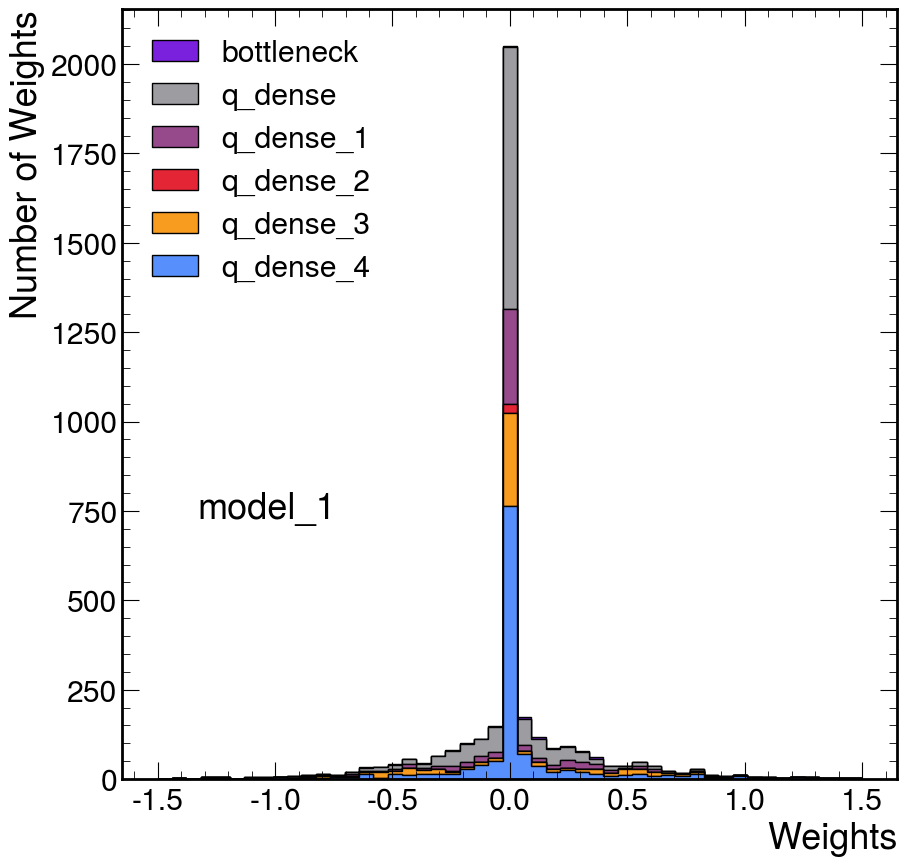

In [26]:
def doWeights(model):

    allWeightsByLayer = {}
    for layer in model.layers:
        if (layer._name).find("batch")!=-1 or len(layer.get_weights())<1:
            continue 
        weights=layer.weights[0].numpy().flatten()  
        allWeightsByLayer[layer._name] = weights
        print('Layer {}: % of zeros = {}'.format(layer._name,np.sum(weights==0)/np.size(weights)))

    labelsW = []
    histosW = []

    for key in reversed(sorted(allWeightsByLayer.keys())):
        labelsW.append(key)
        histosW.append(allWeightsByLayer[key])

    fig = plt.figure(figsize=(10,10))
    bins = np.linspace(-1.5, 1.5, 50)
    plt.hist(histosW,bins,histtype='stepfilled',stacked=True,label=labelsW, edgecolor='black')
    plt.legend(frameon=False,loc='upper left')
    plt.ylabel('Number of Weights')
    plt.xlabel('Weights')
    plt.figtext(0.2, 0.38,model._name, wrap=True, horizontalalignment='left',verticalalignment='center')
    
doWeights(autoencoder) 
doWeights(qp_autoencoder) 

Compare the performance to the floating-point precision, unpruned model.

In [27]:
bkg_prediction = qp_autoencoder.predict(X_test)
signal_prediction = qp_autoencoder.predict(signal_test_data)

# compute loss value of input data versus AE reconstructed data
q_mse_sm = mse_loss(X_test, bkg_prediction.astype(np.float32)).numpy()
q_mse_bsm = mse_loss(signal_test_data,signal_prediction.astype(np.float32)).numpy()

target_background = np.zeros(q_mse_sm.shape[0])

plt.figure(figsize=(8,8))
trueVal = np.concatenate((np.ones(q_mse_bsm.shape[0]), target_background)) # anomaly=1, bkg=0
predVal_loss = np.concatenate((q_mse_bsm, q_mse_sm))

q_fpr_loss, q_tpr_loss, q_threshold_loss = roc_curve(trueVal, predVal_loss)

q_auc_loss = auc(q_fpr_loss, q_tpr_loss)

16478/16478 [==============================] - 26s 2ms/step


<Figure size 800x800 with 0 Axes>

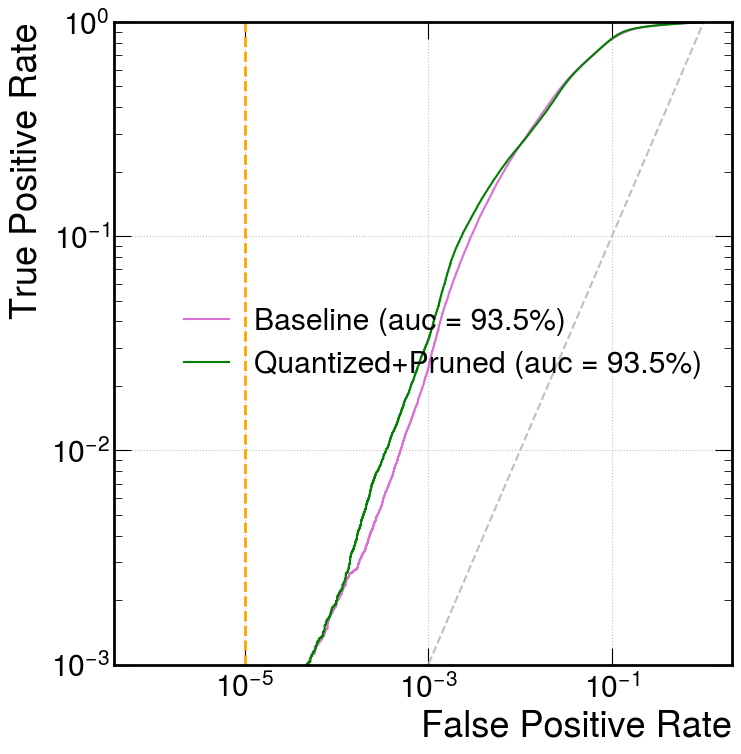

In [29]:
plt.figure(figsize=(8,8))
    
plt.plot(fpr_loss, tpr_loss, "-", label='Baseline (auc = %.1f%%)'%(auc_loss*100.), linewidth=1.5, color = "orchid")
plt.plot(q_fpr_loss, q_tpr_loss, "-", label='Quantized+Pruned (auc = %.1f%%)'%(q_auc_loss*100.), linewidth=1.5, color = "green")

plt.semilogx()
plt.semilogy()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc='center right')
plt.grid(True)
plt.tight_layout()
plt.ylim(0.001,1)
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='orange', linestyle='dashed', linewidth=2) # threshold value for measuring anomaly detection efficiency

plt.savefig('roc_curve_quantized.png', dpi=300)

plt.show()